# Demographics 

Author: Mo Al Elew

I read in and transform demographics and GIS data.

**What notebook does/produces:**

Data files containing racial demographics and median household income (when available) at the ZCTA, Tract, County, City/CDP, Block group, and Block level. I also merge this transformed data with their corresponding TIGER GIS file.

**Issue/problem being solved:**

The relevant data is sourced from multiple Census data tables and TIGER/Line Shapefiles. I need the data joined into a single table.

**Strategy to solve:**

The general pattern:

1. Read in the separate data files
2. Join on geographic identified `GEOID`
3. Run any necessary transformation or calculations
4. Merge the census data with the geographic data
5. Export

**Sources:**

- data.census.gov
- https://www2.census.gov/geo/tiger/TIGER2020/


In [1]:
import zipfile
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd

# Read helper functions

In [2]:
# 2022 data file names
DP_DATA_FILE_NAME = "ACSDP5Y2022.DP05-Data.csv"
INCOME_DATA_FILE_NAME = "ACSST5Y2022.S1901-Data.csv"

In [3]:
def read_data_file(zip_fp, data_file_name, **read_csv_options):
    with zipfile.ZipFile(zip_fp) as z:
        with z.open(data_file_name) as f:
            return pd.read_csv(f, **read_csv_options)

In [4]:
def read_acs_data(
    acs_data_zip_fp, data_file_name, columns_codes_to_extract=None, column_renames=None
):
    df = read_data_file(acs_data_zip_fp, data_file_name, **{"skiprows": [1]})
    if columns_codes_to_extract:
        df = df[columns_codes_to_extract].copy()
    if column_renames:
        df = df.rename(columns=column_renames)
    return df

In [5]:
def read_dec_data(
    data_file_name, columns_codes_to_extract=None, column_renames=None
):
    df = pd.read_csv(data_file_name, thousands=",")
    if columns_codes_to_extract:
        df = df[columns_codes_to_extract].copy()
    if column_renames:
        df = df.rename(columns=column_renames)
    return df

# Read data columns mappings

Column codes and their renames

In [6]:
DEMOGRAPHIC_DATA_COLUMNS_FP = "./inputs/column_mappings/DP05_demographic_data_columns.csv"
INCOME_DATA_COLUMNS_FP = "./inputs/column_mappings/S1901_income_data_columns.csv"

In [7]:
DF_DEMOGRAPHIC_COLUMNS = pd.read_csv(DEMOGRAPHIC_DATA_COLUMNS_FP)
DF_DEMOGRAPHIC_COLUMNS = DF_DEMOGRAPHIC_COLUMNS.dropna(subset=["RENAME"])
demographic_columns_to_extract = list(DF_DEMOGRAPHIC_COLUMNS["KEY"])
demographic_columns_renames = dict(
    zip(DF_DEMOGRAPHIC_COLUMNS["KEY"], DF_DEMOGRAPHIC_COLUMNS["RENAME"])
)
DF_DEMOGRAPHIC_COLUMNS.head()

,KEY,NAME,RENAME
0,GEO_ID,Geography,geo_id
1,NAME,Geographic Area Name,geo_name
2,DP05_0001E,Estimate!!SEX AND AGE!!Total population,total_pop
31,DP05_0073PE,Percent!!HISPANIC OR LATINO AND RACE!!Total po...,latin_pct
32,DP05_0079PE,Percent!!HISPANIC OR LATINO AND RACE!!Total po...,white_pct


In [8]:
DF_INCOME_COLUMNS = pd.read_csv(INCOME_DATA_COLUMNS_FP)
DF_INCOME_COLUMNS = DF_INCOME_COLUMNS.dropna(subset=["RENAME"])
income_columns_to_extract = list(DF_INCOME_COLUMNS["KEY"])
income_columns_renames = dict(
    zip(DF_INCOME_COLUMNS["KEY"], DF_INCOME_COLUMNS["RENAME"])
)
DF_INCOME_COLUMNS.head()

,KEY,NAME,RENAME
0,GEO_ID,Geography,geo_id
1,NAME,Geographic Area Name,geo_name
24,S1901_C01_012E,Estimate!!Households!!Median income (dollars),median_income


# ZCTA

- Read in census demographics for MI ZCTAs
- Data is divided by inline index-header
- We use this index-header to construct a list of the MI ZCTAs

## Constants

In [9]:
MI_ZCTA_DEMOGRAPHIC_DATA_FP = "./inputs/census_data/ACSDP5Y2022.DP05_2024-01-03T155759.zip"
MI_ZCTA_INCOME_DATA_FP = "./inputs/census_data/ACSST5Y2022.S1901_2024-01-04T171508.zip"
ZCTA_GIS_FP = "./inputs/tiger_files/tl_2023_us_zcta520.zip"

ZCTA_LEN = 5
ZCTA_PREFIX = "ZCTA5 "

ZCTA_DEMOGRAPHICS_EXPORT_FP = "./outputs/zcta_demographics.csv"
ZCTA_MAP_EXPORT_FP = "./outputs/zcta_demographics_map.geojson"

## Download ZCTA

In [10]:
if not Path(ZCTA_GIS_FP).is_file():
    !wget -P ./inputs https://www2.census.gov/geo/tiger/TIGER2023/ZCTA520/tl_2023_us_zcta520.zip

## Read data

In [11]:
DF_ZCTA_DEMOGRAPHICS = read_acs_data(
    MI_ZCTA_DEMOGRAPHIC_DATA_FP,
    DP_DATA_FILE_NAME,
    demographic_columns_to_extract,
    demographic_columns_renames,
)
mi_zctas = list(DF_ZCTA_DEMOGRAPHICS["geo_id"].str.slice(-1 * ZCTA_LEN))
assert all([len(zcta) == ZCTA_LEN for zcta in mi_zctas])

In [12]:
DF_ZCTA_INCOME = read_acs_data(
    MI_ZCTA_INCOME_DATA_FP,
    INCOME_DATA_FILE_NAME,
    income_columns_to_extract,
    income_columns_renames,
)
DF_ZCTA_INCOME

,geo_id,geo_name,median_income
0,860Z200US48001,ZCTA5 48001,63272
1,860Z200US48002,ZCTA5 48002,87000
2,860Z200US48003,ZCTA5 48003,85946
3,860Z200US48005,ZCTA5 48005,106190
4,860Z200US48006,ZCTA5 48006,71208
...,...,...,...
988,860Z200US49968,ZCTA5 49968,44083
989,860Z200US49969,ZCTA5 49969,55694
990,860Z200US49970,ZCTA5 49970,58194
991,860Z200US49971,ZCTA5 49971,44602


<Axes: >

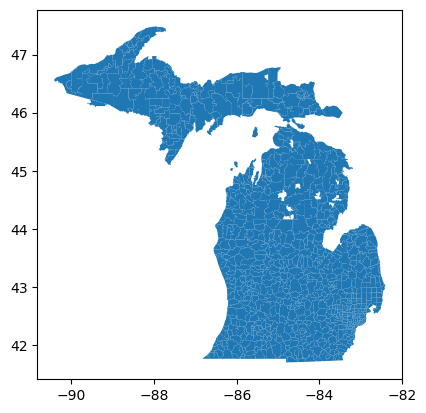

In [13]:
gdf_zcta = gpd.read_file(ZCTA_GIS_FP)
is_michigan_zcta = gdf_zcta["ZCTA5CE20"].isin(mi_zctas)
gdf_mi_zcta = gdf_zcta[is_michigan_zcta].copy()
assert len(gdf_mi_zcta) == len(mi_zctas)
del gdf_zcta
gdf_mi_zcta.plot()

In [14]:
gdf_mi_zcta.columns = [col.lower() for col in gdf_mi_zcta.columns]
gdf_mi_zcta

,zcta5ce20,geoid20,geoidfq20,classfp20,mtfcc20,funcstat20,aland20,awater20,intptlat20,intptlon20,geometry
14928,48756,48756,860Z200US48756,B5,G6350,S,206826376,4967622,+44.2337465,-083.9733794,"POLYGON ((-84.07938 44.20834, -84.07921 44.208..."
14929,49721,49721,860Z200US49721,B5,G6350,S,690877520,99353628,+45.5741794,-084.4554460,"POLYGON ((-84.72290 45.67864, -84.72290 45.678..."
14930,49648,49648,860Z200US49648,B5,G6350,S,70622043,58490496,+44.9976862,-085.3388085,"POLYGON ((-85.40704 44.95004, -85.40631 44.953..."
14931,49854,49854,860Z200US49854,B5,G6350,S,1227454533,89404938,+46.0761717,-086.3458028,"POLYGON ((-86.61540 46.33326, -86.60496 46.333..."
14932,49783,49783,860Z200US49783,B5,G6350,S,385095820,114621694,+46.4169009,-084.2890536,"POLYGON ((-84.48931 46.43857, -84.47940 46.448..."
...,...,...,...,...,...,...,...,...,...,...,...
15916,48208,48208,860Z200US48208,B5,G6350,S,8311346,0,+42.3484859,-083.0917812,"POLYGON ((-83.11153 42.35575, -83.11142 42.355..."
15917,48212,48212,860Z200US48212,B5,G6350,S,13702262,0,+42.4099998,-083.0559732,"POLYGON ((-83.08321 42.42524, -83.08254 42.425..."
15918,48101,48101,860Z200US48101,B5,G6350,S,18244427,41189,+42.2594735,-083.2103905,"POLYGON ((-83.23191 42.26988, -83.23102 42.269..."
15919,48185,48185,860Z200US48185,B5,G6350,S,31526594,23686,+42.3339011,-083.3842091,"POLYGON ((-83.43004 42.35247, -83.42925 42.352..."


## Merge

In [15]:
df_zcta_income_demographics = pd.merge(
    DF_ZCTA_DEMOGRAPHICS, DF_ZCTA_INCOME, validate="1:1"
)
df_zcta_income_demographics

,geo_id,geo_name,total_pop,latin_pct,white_pct,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,...,total_pop_race,latin_tot,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot,median_income
0,860Z200US48001,ZCTA5 48001,11691,1.9,93.7,0.3,0.1,1.3,0.0,0.0,...,11691,217,10960,39,10,155,0,2,308,63272
1,860Z200US48002,ZCTA5 48002,3121,0.8,97.8,0.0,0.0,0.0,0.0,0.0,...,3121,24,3051,0,0,0,0,1,45,87000
2,860Z200US48003,ZCTA5 48003,5860,4.2,92.1,0.0,0.1,1.0,0.0,1.6,...,5860,245,5397,0,6,56,0,95,61,85946
3,860Z200US48005,ZCTA5 48005,5317,0.6,96.9,0.2,0.2,0.1,0.0,0.0,...,5317,33,5150,10,13,3,0,0,108,106190
4,860Z200US48006,ZCTA5 48006,3945,3.6,94.0,0.2,0.0,0.1,0.0,0.0,...,3945,141,3709,8,0,4,0,0,83,71208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,860Z200US49968,ZCTA5 49968,2124,0.7,93.9,0.2,0.5,0.7,0.0,0.0,...,2124,15,1994,5,11,14,0,0,85,44083
989,860Z200US49969,ZCTA5 49969,1039,1.9,72.3,2.9,17.1,0.3,0.0,0.0,...,1039,20,751,30,178,3,0,0,57,55694
990,860Z200US49970,ZCTA5 49970,277,0.4,99.6,0.0,0.0,0.0,0.0,0.0,...,277,1,276,0,0,0,0,0,0,58194
991,860Z200US49971,ZCTA5 49971,415,0.0,94.9,0.0,0.5,1.4,0.0,0.0,...,415,0,394,0,2,6,0,0,13,44602


In [16]:
gdf_zcta_demographics = gdf_mi_zcta.merge(
    df_zcta_income_demographics, left_on="geoidfq20", right_on="geo_id", validate="1:1"
)
assert len(gdf_zcta_demographics) == len(df_zcta_income_demographics) == len(mi_zctas)
gdf_zcta_demographics

,zcta5ce20,geoid20,geoidfq20,classfp20,mtfcc20,funcstat20,aland20,awater20,intptlat20,intptlon20,...,total_pop_race,latin_tot,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot,median_income
0,48756,48756,860Z200US48756,B5,G6350,S,206826376,4967622,+44.2337465,-083.9733794,...,3956,129,3711,16,3,0,0,0,97,39115
1,49721,49721,860Z200US49721,B5,G6350,S,690877520,99353628,+45.5741794,-084.4554460,...,14034,293,12793,113,299,64,3,17,452,58163
2,49648,49648,860Z200US49648,B5,G6350,S,70622043,58490496,+44.9976862,-085.3388085,...,2572,51,2500,3,2,0,0,0,16,85995
3,49854,49854,860Z200US49854,B5,G6350,S,1227454533,89404938,+46.0761717,-086.3458028,...,6172,55,5199,39,390,21,0,2,466,53836
4,49783,49783,860Z200US49783,B5,G6350,S,385095820,114621694,+46.4169009,-084.2890536,...,18905,277,13517,151,2369,171,11,206,2203,57667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,48208,48208,860Z200US48208,B5,G6350,S,8311346,0,+42.3484859,-083.0917812,...,7827,420,1919,5206,6,66,0,24,186,24046
989,48212,48212,860Z200US48212,B5,G6350,S,13702262,0,+42.4099998,-083.0559732,...,43213,186,18047,8984,170,12483,93,1047,2203,37309
990,48101,48101,860Z200US48101,B5,G6350,S,18244427,41189,+42.2594735,-083.2103905,...,28395,3318,22261,1211,14,420,0,129,1042,73792
991,48185,48185,860Z200US48185,B5,G6350,S,31526594,23686,+42.3339011,-083.3842091,...,48622,2005,31041,10654,72,2341,0,154,2355,57353


## Export

In [17]:
DF_ZCTA_DEMOGRAPHICS.to_csv(ZCTA_DEMOGRAPHICS_EXPORT_FP, index=False)
assert gdf_zcta_demographics["white_tot"].sum() > gdf_zcta_demographics["black_tot"].sum()
gdf_zcta_demographics.to_file(ZCTA_MAP_EXPORT_FP, driver="GeoJSON")

# Tract 

## Constants

In [18]:
MI_TRACT_DEMOGRAPHIC_DATA_FP = "./inputs/census_data/ACSDP5Y2022.DP05_2024-01-03T155619.zip"
MI_TRACT_INCOME_DATA_FP = "./inputs/census_data/ACSST5Y2022.S1901_2024-01-04T161101.zip"
TRACT_GIS_FP = "./inputs/tiger_files/tl_2020_26_tract.zip"
TRACT_2010_GIS_FP = "./inputs/tiger_files/tl_2010_us_ttract10.zip"

TRACT_GEO_ID_PREFIX = "1400000US"

TRACT_DEMOGRAPHICS_EXPORT_FP = "./outputs/tract_demographics.csv"
TRACT_MAP_EXPORT_FP = "./outputs/tract_demographics_map.geojson"

## Read data

In [19]:
DF_TRACT_DEMOGRAPHICS = read_acs_data(
    MI_TRACT_DEMOGRAPHIC_DATA_FP,
    DP_DATA_FILE_NAME,
    demographic_columns_to_extract,
    demographic_columns_renames,
)
DF_TRACT_DEMOGRAPHICS.tail()

,geo_id,geo_name,total_pop,latin_pct,white_pct,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,two_plus_pct,total_pop_race,latin_tot,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot
3012,1400000US26165380400,Census Tract 3804; Wexford County; Michigan,4844,1.4,92.6,0.3,0.2,0.5,0.2,0.0,4.7,4844,70,4486,16,11,24,11,0,226
3013,1400000US26165380500,Census Tract 3805; Wexford County; Michigan,6864,3.7,87.9,0.7,0.6,0.3,0.0,0.0,6.7,6864,255,6036,50,38,23,0,0,462
3014,1400000US26165380600,Census Tract 3806; Wexford County; Michigan,3275,0.0,99.5,0.4,0.1,0.0,0.0,0.0,0.0,3275,0,3257,14,4,0,0,0,0
3015,1400000US26165380700,Census Tract 3807; Wexford County; Michigan,3181,0.8,93.8,1.6,0.3,0.0,0.0,0.0,3.4,3181,25,2985,51,11,0,0,0,109
3016,1400000US26165380800,Census Tract 3808; Wexford County; Michigan,3147,2.6,89.6,3.4,0.0,1.8,0.0,0.0,2.5,3147,82,2821,106,0,58,0,0,80


In [20]:
DF_TRACT_INCOME = read_acs_data(
    MI_TRACT_INCOME_DATA_FP,
    INCOME_DATA_FILE_NAME,
    income_columns_to_extract,
    income_columns_renames,
)
DF_TRACT_INCOME

,geo_id,geo_name,median_income
0,1400000US26001000100,Census Tract 1; Alcona County; Michigan,62348
1,1400000US26001970100,Census Tract 9701; Alcona County; Michigan,51031
2,1400000US26001970400,Census Tract 9704; Alcona County; Michigan,48922
3,1400000US26001970500,Census Tract 9705; Alcona County; Michigan,39620
4,1400000US26001970600,Census Tract 9706; Alcona County; Michigan,59022
...,...,...,...
3012,1400000US26165380400,Census Tract 3804; Wexford County; Michigan,79625
3013,1400000US26165380500,Census Tract 3805; Wexford County; Michigan,62417
3014,1400000US26165380600,Census Tract 3806; Wexford County; Michigan,52791
3015,1400000US26165380700,Census Tract 3807; Wexford County; Michigan,45489


In [21]:
df_tract_income_demographics = pd.merge(
    DF_TRACT_DEMOGRAPHICS, DF_TRACT_INCOME, validate="1:1"
)

assert df_tract_income_demographics["geo_id"].str.startswith(
    TRACT_GEO_ID_PREFIX
).sum() == len(df_tract_income_demographics)
df_tract_income_demographics["geo_id"] = df_tract_income_demographics[
    "geo_id"
].str.removeprefix(TRACT_GEO_ID_PREFIX)
mi_tracts = list(df_tract_income_demographics["geo_id"])
df_tract_income_demographics.tail()

,geo_id,geo_name,total_pop,latin_pct,white_pct,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,...,total_pop_race,latin_tot,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot,median_income
3012,26165380400,Census Tract 3804; Wexford County; Michigan,4844,1.4,92.6,0.3,0.2,0.5,0.2,0.0,...,4844,70,4486,16,11,24,11,0,226,79625
3013,26165380500,Census Tract 3805; Wexford County; Michigan,6864,3.7,87.9,0.7,0.6,0.3,0.0,0.0,...,6864,255,6036,50,38,23,0,0,462,62417
3014,26165380600,Census Tract 3806; Wexford County; Michigan,3275,0.0,99.5,0.4,0.1,0.0,0.0,0.0,...,3275,0,3257,14,4,0,0,0,0,52791
3015,26165380700,Census Tract 3807; Wexford County; Michigan,3181,0.8,93.8,1.6,0.3,0.0,0.0,0.0,...,3181,25,2985,51,11,0,0,0,109,45489
3016,26165380800,Census Tract 3808; Wexford County; Michigan,3147,2.6,89.6,3.4,0.0,1.8,0.0,0.0,...,3147,82,2821,106,0,58,0,0,80,60719


In [22]:
gdf_tract = gpd.read_file(TRACT_GIS_FP)
gdf_tract.columns = [col.lower() for col in gdf_tract.columns]
gdf_tract

,statefp,countyfp,tractce,geoid,name,namelsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,26,163,591900,26163591900,5919,Census Tract 5919,G5020,S,5033701,0,+42.0973728,-083.2321517,"POLYGON ((-83.24385 42.08143, -83.24375 42.081..."
1,26,163,592000,26163592000,5920,Census Tract 5920,G5020,S,12758140,4008857,+42.0600376,-083.1989508,"POLYGON ((-83.23187 42.07831, -83.23075 42.079..."
2,26,163,593200,26163593200,5932,Census Tract 5932,G5020,S,2056711,0,+42.1461813,-083.2492300,"POLYGON ((-83.25654 42.15356, -83.25327 42.153..."
3,26,163,594000,26163594000,5940,Census Tract 5940,G5020,S,5032161,169441,+42.1595591,-083.1764750,"POLYGON ((-83.18951 42.14131, -83.18868 42.142..."
4,26,163,594100,26163594100,5941,Census Tract 5941,G5020,S,2479041,0,+42.1484717,-083.1972751,"POLYGON ((-83.20697 42.14824, -83.20675 42.150..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3012,26,081,014100,26081014100,141,Census Tract 141,G5020,S,1860262,0,+42.8910862,-085.6720539,"POLYGON ((-85.68081 42.88419, -85.68024 42.886..."
3013,26,081,014200,26081014200,142,Census Tract 142,G5020,S,4459324,0,+42.8980703,-085.6549544,"POLYGON ((-85.66586 42.91056, -85.66258 42.910..."
3014,26,081,014300,26081014300,143,Census Tract 143,G5020,S,4310328,5120,+42.8705185,-085.6724366,"POLYGON ((-85.68219 42.87818, -85.68214 42.878..."
3015,26,161,980101,26161980101,9801.01,Census Tract 9801.01,G5020,S,721205,0,+42.2764543,-083.7375396,"POLYGON ((-83.74318 42.27361, -83.74312 42.273..."


<Axes: >

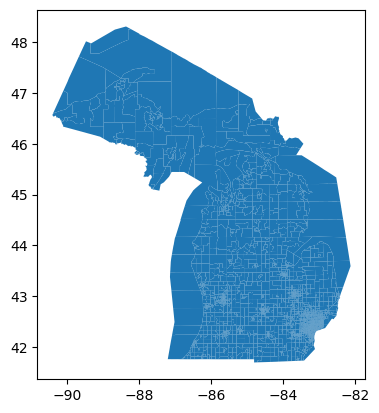

In [23]:
is_mi_tract = gdf_tract["geoid"].isin(mi_tracts)
gdf_mi_tract = gdf_tract[is_mi_tract].copy()
gdf_mi_tract.plot()

## Merge

In [24]:
gdf_mi_tract_demographics = gdf_mi_tract.merge(
    df_tract_income_demographics, left_on="geoid", right_on="geo_id", validate="1:1"
)
assert (
    len(gdf_mi_tract_demographics)
    == len(df_tract_income_demographics)
    == len(mi_tracts)
)
gdf_mi_tract_demographics

,statefp,countyfp,tractce,geoid,name,namelsad,mtfcc,funcstat,aland,awater,...,total_pop_race,latin_tot,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot,median_income
0,26,163,591900,26163591900,5919,Census Tract 5919,G5020,S,5033701,0,...,5610,127,5044,169,9,0,0,0,261,69310
1,26,163,592000,26163592000,5920,Census Tract 5920,G5020,S,12758140,4008857,...,4739,257,3927,257,0,177,0,0,121,101250
2,26,163,593200,26163593200,5932,Census Tract 5932,G5020,S,2056711,0,...,3742,318,3116,133,0,91,0,0,84,81444
3,26,163,594000,26163594000,5940,Census Tract 5940,G5020,S,5032161,169441,...,2405,92,2137,158,0,0,0,0,18,64917
4,26,163,594100,26163594100,5941,Census Tract 5941,G5020,S,2479041,0,...,4287,227,3965,2,0,75,0,0,18,70362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3012,26,081,014100,26081014100,141,Census Tract 141,G5020,S,1860262,0,...,2307,670,977,595,0,29,0,0,36,67163
3013,26,081,014200,26081014200,142,Census Tract 142,G5020,S,4459324,0,...,3521,1269,1788,328,0,0,0,0,136,56330
3014,26,081,014300,26081014300,143,Census Tract 143,G5020,S,4310328,5120,...,2785,805,1623,214,0,0,0,0,143,53446
3015,26,161,980101,26161980101,9801.01,Census Tract 9801.01,G5020,S,721205,0,...,4233,219,2607,146,59,1038,0,0,164,36019


## Export

In [25]:
DF_TRACT_DEMOGRAPHICS.to_csv(TRACT_DEMOGRAPHICS_EXPORT_FP, index=False)
gdf_mi_tract_demographics.to_file(TRACT_MAP_EXPORT_FP, driver="GeoJSON")

# County

## Constants

In [26]:
MI_COUNTY_DEMOGRAPHIC_DATA_FP = "./inputs/census_data/ACSDP5Y2022.DP05_2024-01-03T154529.zip"
MI_COUNTY_INCOME_DATA_FP = "./inputs/census_data/ACSST5Y2022.S1901_2024-01-04T161750.zip"
COUNTY_GIS_FP = "./inputs/tiger_files/tl_2023_us_county.zip"

COUNTY_GEO_ID_PREFIX = "0500000US"

COUNTY_DEMOGRAPHICS_EXPORT_FP = "./outputs/county_demographics.csv"
COUNTY_MAP_EXPORT_FP = "./outputs/county_demographics_map.geojson"

## Read data

In [27]:
DF_COUNTY_DEMOGRAPHICS = read_acs_data(
    MI_COUNTY_DEMOGRAPHIC_DATA_FP,
    DP_DATA_FILE_NAME,
    demographic_columns_to_extract,
    demographic_columns_renames,
)
DF_COUNTY_DEMOGRAPHICS

,geo_id,geo_name,total_pop,latin_pct,white_pct,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,two_plus_pct,total_pop_race,latin_tot,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot
0,0500000US26001,"Alcona County, Michigan",10238,1.8,93.8,0.4,0.3,0.3,0.0,0.3,3.0,10238,189,9603,44,31,32,2,26,311
1,0500000US26003,"Alger County, Michigan",8866,2.0,82.0,7.8,3.2,0.8,0.0,0.1,4.2,8866,175,7266,691,283,70,0,6,375
2,0500000US26005,"Allegan County, Michigan",120189,7.7,86.2,1.3,0.2,0.7,0.0,0.4,3.4,120189,9301,103592,1520,287,872,21,463,4133
3,0500000US26007,"Alpena County, Michigan",28911,1.5,94.2,0.8,0.1,0.5,0.0,0.3,2.6,28911,442,27248,222,30,134,0,97,738
4,0500000US26009,"Antrim County, Michigan",23662,2.5,93.3,0.6,0.5,0.4,0.0,0.4,2.4,23662,583,22075,148,107,85,0,106,558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0500000US26157,"Tuscola County, Michigan",53218,3.8,92.0,1.0,0.3,0.5,0.0,0.1,2.3,53218,2020,48939,558,143,258,0,78,1222
79,0500000US26159,"Van Buren County, Michigan",75636,11.9,79.8,3.4,0.3,0.6,0.0,0.2,3.9,75636,8974,60368,2548,213,472,0,128,2933
80,0500000US26161,"Washtenaw County, Michigan",370231,5.1,68.6,11.4,0.2,9.1,0.0,0.4,5.1,370231,18908,254046,42224,664,33872,121,1609,18787
81,0500000US26163,"Wayne County, Michigan",1781641,6.3,48.7,37.4,0.2,3.4,0.0,0.4,3.6,1781641,112699,866868,666184,3226,61215,314,7876,63259


In [28]:
DF_COUNTY_INCOME = read_acs_data(
    MI_COUNTY_INCOME_DATA_FP,
    INCOME_DATA_FILE_NAME,
    income_columns_to_extract,
    income_columns_renames,
)
DF_COUNTY_INCOME

,geo_id,geo_name,median_income
0,0500000US26001,"Alcona County, Michigan",50295
1,0500000US26003,"Alger County, Michigan",55528
2,0500000US26005,"Allegan County, Michigan",75543
3,0500000US26007,"Alpena County, Michigan",49133
4,0500000US26009,"Antrim County, Michigan",68850
...,...,...,...
78,0500000US26157,"Tuscola County, Michigan",59815
79,0500000US26159,"Van Buren County, Michigan",65531
80,0500000US26161,"Washtenaw County, Michigan",84245
81,0500000US26163,"Wayne County, Michigan",57223


In [29]:
df_county_income_demographics = pd.merge(
    DF_COUNTY_DEMOGRAPHICS, DF_COUNTY_INCOME, validate="1:1"
)

assert df_county_income_demographics["geo_id"].str.startswith(
    COUNTY_GEO_ID_PREFIX
).sum() == len(df_county_income_demographics)
df_county_income_demographics["geo_id"] = df_county_income_demographics[
    "geo_id"
].str.removeprefix(COUNTY_GEO_ID_PREFIX)
mi_counties = list(df_county_income_demographics["geo_id"])
df_county_income_demographics.tail()

,geo_id,geo_name,total_pop,latin_pct,white_pct,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,...,total_pop_race,latin_tot,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot,median_income
78,26157,"Tuscola County, Michigan",53218,3.8,92.0,1.0,0.3,0.5,0.0,0.1,...,53218,2020,48939,558,143,258,0,78,1222,59815
79,26159,"Van Buren County, Michigan",75636,11.9,79.8,3.4,0.3,0.6,0.0,0.2,...,75636,8974,60368,2548,213,472,0,128,2933,65531
80,26161,"Washtenaw County, Michigan",370231,5.1,68.6,11.4,0.2,9.1,0.0,0.4,...,370231,18908,254046,42224,664,33872,121,1609,18787,84245
81,26163,"Wayne County, Michigan",1781641,6.3,48.7,37.4,0.2,3.4,0.0,0.4,...,1781641,112699,866868,666184,3226,61215,314,7876,63259,57223
82,26165,"Wexford County, Michigan",33766,2.3,92.0,0.9,0.3,0.5,0.0,0.0,...,33766,778,31076,289,115,154,15,8,1331,58652


In [30]:
gdf_county = gpd.read_file(COUNTY_GIS_FP)
gdf_county.columns = [col.lower() for col in gdf_county.columns]
gdf_county

,statefp,countyfp,countyns,geoid,geoidfq,name,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,13,123,00351260,13123,0500000US13123,Gilmer,Gilmer County,06,H1,G4020,None,None,None,A,1103893380,12276629,+34.6905232,-084.4548113,"POLYGON ((-84.30237 34.57832, -84.30329 34.577..."
3231,27,135,00659513,27135,0500000US27135,Roseau,Roseau County,06,H1,G4020,None,None,None,A,4329782924,16924046,+48.7610683,-095.8215042,"POLYGON ((-95.25857 48.88666, -95.25707 48.885..."
3232,28,089,00695768,28089,0500000US28089,Madison,Madison County,06,H1,G4020,298,27140,None,A,1849790735,72085470,+32.6343703,-090.0341603,"POLYGON ((-90.14883 32.40026, -90.14890 32.400..."
3233,48,227,01383899,48227,0500000US48227,Howard,Howard County,06,H1,G4020,None,13700,None,A,2333039148,8841781,+32.3034298,-101.4387208,"POLYGON ((-101.18138 32.21252, -101.18138 32.2..."


In [31]:
is_mi_county = gdf_county["geoid"].isin(mi_counties)
gdf_mi_county = gdf_county[is_mi_county]
assert len(gdf_mi_county) == len(mi_counties)
gdf_mi_county

,statefp,countyfp,countyns,geoid,geoidfq,name,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry
50,26,109,01622997,26109,0500000US26109,Menominee,Menominee County,06,H1,G4020,361,31940,None,A,2704053651,761798350,+45.5355685,-087.5014573,"POLYGON ((-87.26421 45.55054, -87.26392 45.550..."
65,26,007,01622946,26007,0500000US26007,Alpena,Alpena County,06,H1,G4020,None,10980,None,A,1481211409,2908626983,+44.8949540,-083.4265739,"POLYGON ((-83.37465 45.20709, -83.36981 45.207..."
76,26,035,01622960,26035,0500000US26035,Clare,Clare County,06,H1,G4020,None,None,None,A,1461703749,28496979,+43.9911368,-084.8383253,"POLYGON ((-84.78346 43.81465, -84.78752 43.814..."
89,26,103,01622994,26103,0500000US26103,Marquette,Marquette County,06,H1,G4020,None,32100,None,A,4685420990,4185337774,+46.6565964,-087.5840278,"POLYGON ((-88.04511 46.83447, -88.04457 46.838..."
96,26,089,01622987,26089,0500000US26089,Leelanau,Leelanau County,06,H1,G4020,None,45900,None,A,899241892,5659105321,+45.1461816,-086.0515740,"POLYGON ((-85.65918 44.77531, -85.65924 44.775..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,26,029,01622957,26029,0500000US26029,Charlevoix,Charlevoix County,06,H1,G4020,None,None,None,A,1078288790,2522931117,+45.6185538,-085.5436841,"POLYGON ((-84.73430 45.20194, -84.73432 45.201..."
2956,26,121,01623003,26121,0500000US26121,Muskegon,Muskegon County,06,H1,G4020,266,34740,None,A,1305130151,2476314283,+43.4287388,-086.4209083,"POLYGON ((-85.90839 43.20592, -85.90810 43.196..."
3024,26,041,01622963,26041,0500000US26041,Delta,Delta County,06,H1,G4020,None,21540,None,A,3033120256,2124407010,+45.8052288,-086.9019375,"POLYGON ((-87.36801 45.94134, -87.36800 45.943..."
3035,26,073,01622979,26073,0500000US26073,Isabella,Isabella County,06,H1,G4020,394,34380,None,A,1483287235,12943517,+43.6452331,-084.8394245,"POLYGON ((-84.76067 43.81469, -84.76015 43.814..."


## Merge

In [32]:
gdf_mi_county_demographics = gdf_mi_county.merge(
    df_county_income_demographics, left_on="geoid", right_on="geo_id", validate="1:1"
)
assert (
    len(gdf_mi_county_demographics)
    == len(df_county_income_demographics)
    == len(mi_counties)
)
gdf_mi_county_demographics

,statefp,countyfp,countyns,geoid,geoidfq,name,namelsad,lsad,classfp,mtfcc,...,total_pop_race,latin_tot,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot,median_income
0,26,109,01622997,26109,0500000US26109,Menominee,Menominee County,06,H1,G4020,...,23433,499,21592,120,498,89,0,7,628,54074
1,26,007,01622946,26007,0500000US26007,Alpena,Alpena County,06,H1,G4020,...,28911,442,27248,222,30,134,0,97,738,49133
2,26,035,01622960,26035,0500000US26035,Clare,Clare County,06,H1,G4020,...,30998,713,29088,212,119,102,0,32,732,47816
3,26,103,01622994,26103,0500000US26103,Marquette,Marquette County,06,H1,G4020,...,66376,1126,60688,1043,738,427,18,111,2225,63115
4,26,089,01622987,26089,0500000US26089,Leelanau,Leelanau County,06,H1,G4020,...,22426,978,20088,79,593,132,17,63,476,82345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,26,029,01622957,26029,0500000US26029,Charlevoix,Charlevoix County,06,H1,G4020,...,26174,631,24244,132,241,109,0,48,769,69764
79,26,121,01623003,26121,0500000US26121,Muskegon,Muskegon County,06,H1,G4020,...,175947,10739,132454,22958,1087,1181,40,120,7368,61347
80,26,041,01622963,26041,0500000US26041,Delta,Delta County,06,H1,G4020,...,36839,548,33485,104,680,72,1,67,1882,53852
81,26,073,01622979,26073,0500000US26073,Isabella,Isabella County,06,H1,G4020,...,64938,2840,54720,1584,1709,956,28,244,2857,52638


## Export

In [33]:
DF_COUNTY_DEMOGRAPHICS.to_csv(COUNTY_DEMOGRAPHICS_EXPORT_FP, index=False)
gdf_mi_county_demographics.to_file(COUNTY_MAP_EXPORT_FP, driver="GeoJSON")

# Block group

## Constants


In [34]:
RACE_DATA_FP = "./inputs/census_data/ACSDT5Y2022.B03002_2024-02-26T132852.zip"
INCOME_DATA_FP = "./inputs/census_data/ACSDT5Y2022.B19013_2024-02-26T133619.zip"

DP_DATA_FILE_NAME = "ACSDT5Y2022.B03002-Data.csv"
INCOME_FILE_NAME = "ACSDT5Y2022.B19013-Data.csv"

RACE_DATA_COL_MAP = "./inputs/column_mappings/B03002_bg_demographic_data_columns.csv"
INCOME_DATA_COL_MAP = "./inputs/column_mappings/B19013_bg_income_data_columns.csv"

BG_GIS_FILE = "./inputs/tiger_files/tl_2020_26_bg.zip"

## Read data

In [35]:
RACE_COL_MAP = pd.read_csv(RACE_DATA_COL_MAP)
RACE_COL_MAP = RACE_COL_MAP.dropna(subset=["RENAME"])

race_col_renames = dict(zip(RACE_COL_MAP["KEY"], RACE_COL_MAP["RENAME"]))

INCOME_COL_MAP = pd.read_csv(INCOME_DATA_COL_MAP)
INCOME_COL_MAP = INCOME_COL_MAP.dropna(subset=["RENAME"])

income_col_renames = dict(zip(INCOME_COL_MAP["KEY"], INCOME_COL_MAP["RENAME"]))

In [36]:
DF_RACE_BG = read_acs_data(
    RACE_DATA_FP, DP_DATA_FILE_NAME, list(RACE_COL_MAP["KEY"]), race_col_renames
)
DF_RACE_BG

,geo_id,geo_name,tot_pop,white_tot,black_tot,aian_tot,asian_tot,nhopi_tot,other_tot,two_more_tot,latin_tot
0,1500000US260010001001,Block Group 1; Census Tract 1; Alcona County; ...,666,591,8,0,0,0,17,34,16
1,1500000US260010001002,Block Group 2; Census Tract 1; Alcona County; ...,1032,988,0,0,0,0,0,24,20
2,1500000US260019701001,Block Group 1; Census Tract 9701; Alcona Count...,997,950,0,0,18,0,5,10,14
3,1500000US260019701002,Block Group 2; Census Tract 9701; Alcona Count...,1409,1284,9,11,2,0,0,52,51
4,1500000US260019704001,Block Group 1; Census Tract 9704; Alcona Count...,1338,1277,2,4,0,0,4,32,19
...,...,...,...,...,...,...,...,...,...,...,...
8381,1500000US261653807002,Block Group 2; Census Tract 3807; Wexford Coun...,1452,1330,29,0,0,0,0,68,25
8382,1500000US261653807003,Block Group 3; Census Tract 3807; Wexford Coun...,449,427,22,0,0,0,0,0,0
8383,1500000US261653808001,Block Group 1; Census Tract 3808; Wexford Coun...,560,524,0,0,0,0,0,11,25
8384,1500000US261653808002,Block Group 2; Census Tract 3808; Wexford Coun...,609,533,13,0,58,0,0,5,0


In [37]:
DF_INCOME_BG = read_acs_data(
    INCOME_DATA_FP, INCOME_FILE_NAME, list(INCOME_COL_MAP["KEY"]), income_col_renames
)
DF_INCOME_BG = DF_INCOME_BG[["geo_id", "median_income"]].copy()
DF_INCOME_BG

,geo_id,median_income
0,1500000US260010001001,60565
1,1500000US260010001002,66429
2,1500000US260019701001,52308
3,1500000US260019701002,50417
4,1500000US260019704001,47557
...,...,...
8381,1500000US261653807002,47688
8382,1500000US261653807003,31667
8383,1500000US261653808001,62311
8384,1500000US261653808002,36023


In [38]:
gdf_bg = gpd.read_file(BG_GIS_FILE)
gdf_bg.columns = [col.lower() for col in gdf_bg.columns]
gdf_bg = gdf_bg.rename(columns={"geoid": "geo_id"})
bg_fips_len = gdf_bg["geo_id"].str.len()[0]

## Calculate percentages

In [39]:
df_race_bg = DF_RACE_BG.set_index(["geo_id", "geo_name"])
pop_by_race_group = df_race_bg[df_race_bg.columns[1:]].to_numpy()
tot_pop_divisor = pd.DataFrame(df_race_bg["tot_pop"]).replace(0, 1).to_numpy()

pct_col_names = [col.replace("tot", "pct") for col in df_race_bg.columns[1:]]

df_race_bg[pct_col_names] = np.round(pop_by_race_group / tot_pop_divisor, 3) * 100
df_race_bg = df_race_bg.reset_index()
df_race_bg

,geo_id,geo_name,tot_pop,white_tot,black_tot,aian_tot,asian_tot,nhopi_tot,other_tot,two_more_tot,latin_tot,white_pct,black_pct,aian_pct,asian_pct,nhopi_pct,other_pct,two_more_pct,latin_pct
0,1500000US260010001001,Block Group 1; Census Tract 1; Alcona County; ...,666,591,8,0,0,0,17,34,16,88.7,1.2,0.0,0.0,0.0,2.6,5.1,2.4
1,1500000US260010001002,Block Group 2; Census Tract 1; Alcona County; ...,1032,988,0,0,0,0,0,24,20,95.7,0.0,0.0,0.0,0.0,0.0,2.3,1.9
2,1500000US260019701001,Block Group 1; Census Tract 9701; Alcona Count...,997,950,0,0,18,0,5,10,14,95.3,0.0,0.0,1.8,0.0,0.5,1.0,1.4
3,1500000US260019701002,Block Group 2; Census Tract 9701; Alcona Count...,1409,1284,9,11,2,0,0,52,51,91.1,0.6,0.8,0.1,0.0,0.0,3.7,3.6
4,1500000US260019704001,Block Group 1; Census Tract 9704; Alcona Count...,1338,1277,2,4,0,0,4,32,19,95.4,0.1,0.3,0.0,0.0,0.3,2.4,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8381,1500000US261653807002,Block Group 2; Census Tract 3807; Wexford Coun...,1452,1330,29,0,0,0,0,68,25,91.6,2.0,0.0,0.0,0.0,0.0,4.7,1.7
8382,1500000US261653807003,Block Group 3; Census Tract 3807; Wexford Coun...,449,427,22,0,0,0,0,0,0,95.1,4.9,0.0,0.0,0.0,0.0,0.0,0.0
8383,1500000US261653808001,Block Group 1; Census Tract 3808; Wexford Coun...,560,524,0,0,0,0,0,11,25,93.6,0.0,0.0,0.0,0.0,0.0,2.0,4.5
8384,1500000US261653808002,Block Group 2; Census Tract 3808; Wexford Coun...,609,533,13,0,58,0,0,5,0,87.5,2.1,0.0,9.5,0.0,0.0,0.8,0.0


## Merge

In [40]:
assert len(df_race_bg) == len(DF_INCOME_BG) == df_race_bg["geo_id"].nunique()
pre_merge_entry_count = len(df_race_bg)

df_bg = df_race_bg.merge(DF_INCOME_BG, validate="1:1")

df_bg["geo_id"] = df_bg["geo_id"].str.slice(-1 * bg_fips_len).copy()
post_merge_entry_count = len(df_bg)
assert pre_merge_entry_count == post_merge_entry_count

df_bg

,geo_id,geo_name,tot_pop,white_tot,black_tot,aian_tot,asian_tot,nhopi_tot,other_tot,two_more_tot,latin_tot,white_pct,black_pct,aian_pct,asian_pct,nhopi_pct,other_pct,two_more_pct,latin_pct,median_income
0,260010001001,Block Group 1; Census Tract 1; Alcona County; ...,666,591,8,0,0,0,17,34,16,88.7,1.2,0.0,0.0,0.0,2.6,5.1,2.4,60565
1,260010001002,Block Group 2; Census Tract 1; Alcona County; ...,1032,988,0,0,0,0,0,24,20,95.7,0.0,0.0,0.0,0.0,0.0,2.3,1.9,66429
2,260019701001,Block Group 1; Census Tract 9701; Alcona Count...,997,950,0,0,18,0,5,10,14,95.3,0.0,0.0,1.8,0.0,0.5,1.0,1.4,52308
3,260019701002,Block Group 2; Census Tract 9701; Alcona Count...,1409,1284,9,11,2,0,0,52,51,91.1,0.6,0.8,0.1,0.0,0.0,3.7,3.6,50417
4,260019704001,Block Group 1; Census Tract 9704; Alcona Count...,1338,1277,2,4,0,0,4,32,19,95.4,0.1,0.3,0.0,0.0,0.3,2.4,1.4,47557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8381,261653807002,Block Group 2; Census Tract 3807; Wexford Coun...,1452,1330,29,0,0,0,0,68,25,91.6,2.0,0.0,0.0,0.0,0.0,4.7,1.7,47688
8382,261653807003,Block Group 3; Census Tract 3807; Wexford Coun...,449,427,22,0,0,0,0,0,0,95.1,4.9,0.0,0.0,0.0,0.0,0.0,0.0,31667
8383,261653808001,Block Group 1; Census Tract 3808; Wexford Coun...,560,524,0,0,0,0,0,11,25,93.6,0.0,0.0,0.0,0.0,0.0,2.0,4.5,62311
8384,261653808002,Block Group 2; Census Tract 3808; Wexford Coun...,609,533,13,0,58,0,0,5,0,87.5,2.1,0.0,9.5,0.0,0.0,0.8,0.0,36023


In [41]:
assert len(gdf_bg) == post_merge_entry_count
gdf_bg_merged = gdf_bg.merge(df_bg, validate="1:1")

## Export

In [42]:
gdf_bg_merged.to_file("./outputs/bg_demographics_map.geojson", driver="GeoJSON")
gdf_bg_merged

,statefp,countyfp,tractce,blkgrpce,geo_id,namelsad,mtfcc,funcstat,aland,awater,...,latin_tot,white_pct,black_pct,aian_pct,asian_pct,nhopi_pct,other_pct,two_more_pct,latin_pct,median_income
0,26,161,410400,3,261614104003,Block Group 3,G5030,S,1435618,0,...,21,82.0,6.8,0.0,7.1,0.0,0.0,2.1,2.0,95662
1,26,161,400800,2,261614008002,Block Group 2,G5030,S,302334,12839,...,139,71.3,1.5,0.0,16.5,0.0,0.0,3.5,7.2,24563
2,26,161,410100,1,261614101001,Block Group 1,G5030,S,476665,0,...,229,39.5,39.2,0.0,3.6,0.0,0.0,3.6,14.1,37708
3,26,161,405400,1,261614054001,Block Group 1,G5030,S,867179,0,...,14,88.1,6.2,0.0,2.4,0.0,0.0,2.1,1.2,70436
4,26,161,416000,1,261614160001,Block Group 1,G5030,S,1202824,6902,...,283,43.9,18.3,0.0,4.4,0.0,0.0,11.3,22.0,78066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8381,26,163,589402,1,261635894021,Block Group 1,G5030,S,4205476,98717,...,8,85.1,10.9,0.0,0.0,0.0,0.0,2.8,1.2,58293
8382,26,163,589401,1,261635894011,Block Group 1,G5030,S,9706203,4401,...,0,87.3,0.0,0.0,4.3,0.0,0.0,8.4,0.0,73212
8383,26,163,579501,1,261635795011,Block Group 1,G5030,S,368475,0,...,565,21.3,20.5,0.0,0.0,3.8,0.7,13.7,40.0,-
8384,26,163,589402,2,261635894022,Block Group 2,G5030,S,7591261,3873,...,0,47.8,33.6,0.0,0.0,0.0,0.0,18.7,0.0,81651


# Block

## Constants

In [43]:
BLOCKS_GIS_FP = "../01_demographics/inputs/tiger_files/tl_2020_26_tabblock20.zip"
BLOCKS_MI_FP = "./inputs/census_data/DECENNIALDHC2020.P9_2024-03-14T121909.zip"
BLOCKS_WAYNE_FP = "./inputs/census_data/DECENNIALDHC2020.P9_2024-03-14T121826.zip"

BLOCK_DATA_FILE_NAME = "DECENNIALDHC2020.P9-Data.csv"

DEMOGRAPHIC_BLOCK_DATA_COLUMNS_FP = "./inputs/column_mappings/P9_block_data_columns.csv"

EXPORT_COLS = [
    "geo_id",
    "geo_name",
    "tot_pop",
    "latin_tot",
    "white_tot",
    "black_tot",
    "aian_tot",
    "asian_tot",
    "nhpi_tot",
    "other_tot",
    "two_plus_tot",
    "latin_pct",
    "white_pct",
    "black_pct",
    "aian_pct",
    "asian_pct",
    "nhpi_pct",
    "other_pct",
    "two_plus_pct",
    "geometry",
]

In [44]:
if not Path(BLOCKS_GIS_FP).is_file():
    !wget -P ./inputs https://www2.census.gov/geo/tiger/TIGER2020/TABBLOCK20/tl_2020_26_tabblock20.zip

## Read data

In [45]:
DF_DEMOGRAPHIC_COLUMNS = pd.read_csv(DEMOGRAPHIC_BLOCK_DATA_COLUMNS_FP)
DF_DEMOGRAPHIC_COLUMNS = DF_DEMOGRAPHIC_COLUMNS.dropna(subset=["RENAME"])
demographic_columns_to_extract = list(DF_DEMOGRAPHIC_COLUMNS["KEY"])
demographic_columns_renames = dict(
    zip(DF_DEMOGRAPHIC_COLUMNS["KEY"], DF_DEMOGRAPHIC_COLUMNS["RENAME"])
)
DF_DEMOGRAPHIC_COLUMNS.head()

,KEY,NAME,RENAME
0,GEO_ID,Geography,geo_id
1,NAME,Geographic Area Name,geo_name
2,P9_001N,!!Total:,tot_pop
3,P9_002N,!!Total:!!Hispanic or Latino,latin_tot
6,P9_005N,!!Total:!!Not Hispanic or Latino:!!Population...,white_tot


In [46]:
DF_RACE_BLOCKS = read_acs_data(
    BLOCKS_MI_FP,
    BLOCK_DATA_FILE_NAME,
    demographic_columns_renames.keys(),
    demographic_columns_renames,
)
DF_RACE_BLOCKS

,geo_id,geo_name,tot_pop,latin_tot,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot
0,1000000US260010001001000,"Block 1000, Block Group 1, Census Tract 1, Alc...",23,0,23,0,0,0,0,0,0
1,1000000US260010001001001,"Block 1001, Block Group 1, Census Tract 1, Alc...",1,0,1,0,0,0,0,0,0
2,1000000US260010001001002,"Block 1002, Block Group 1, Census Tract 1, Alc...",3,0,1,0,0,0,0,0,2
3,1000000US260010001001003,"Block 1003, Block Group 1, Census Tract 1, Alc...",7,2,5,0,0,0,0,0,0
4,1000000US260010001001004,"Block 1004, Block Group 1, Census Tract 1, Alc...",2,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
254725,1000000US261653808003032,"Block 3032, Block Group 3, Census Tract 3808, ...",3,0,3,0,0,0,0,0,0
254726,1000000US261653808003033,"Block 3033, Block Group 3, Census Tract 3808, ...",63,3,54,0,1,1,0,0,4
254727,1000000US261653808003034,"Block 3034, Block Group 3, Census Tract 3808, ...",9,0,9,0,0,0,0,0,0
254728,1000000US261653808003035,"Block 3035, Block Group 3, Census Tract 3808, ...",11,0,10,0,0,0,0,0,1


## Calculate percentages

In [47]:
df_race_blocks = DF_RACE_BLOCKS.set_index(["geo_id", "geo_name"])
pop_by_race_group = df_race_blocks[df_race_blocks.columns[1:]].to_numpy()
tot_pop_divisor = pd.DataFrame(df_race_blocks["tot_pop"]).replace(0, 1).to_numpy()

pct_col_names = [col.replace("tot", "pct") for col in df_race_blocks.columns[1:]]

df_race_blocks[pct_col_names] = np.round(pop_by_race_group / tot_pop_divisor, 3) * 100
df_race_blocks = df_race_blocks.reset_index()
df_race_blocks

,geo_id,geo_name,tot_pop,latin_tot,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot,latin_pct,white_pct,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,two_plus_pct
0,1000000US260010001001000,"Block 1000, Block Group 1, Census Tract 1, Alc...",23,0,23,0,0,0,0,0,0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000000US260010001001001,"Block 1001, Block Group 1, Census Tract 1, Alc...",1,0,1,0,0,0,0,0,0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000000US260010001001002,"Block 1002, Block Group 1, Census Tract 1, Alc...",3,0,1,0,0,0,0,0,2,0.0,33.3,0.0,0.0,0.0,0.0,0.0,66.7
3,1000000US260010001001003,"Block 1003, Block Group 1, Census Tract 1, Alc...",7,2,5,0,0,0,0,0,0,28.6,71.4,0.0,0.0,0.0,0.0,0.0,0.0
4,1000000US260010001001004,"Block 1004, Block Group 1, Census Tract 1, Alc...",2,0,2,0,0,0,0,0,0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254725,1000000US261653808003032,"Block 3032, Block Group 3, Census Tract 3808, ...",3,0,3,0,0,0,0,0,0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
254726,1000000US261653808003033,"Block 3033, Block Group 3, Census Tract 3808, ...",63,3,54,0,1,1,0,0,4,4.8,85.7,0.0,1.6,1.6,0.0,0.0,6.3
254727,1000000US261653808003034,"Block 3034, Block Group 3, Census Tract 3808, ...",9,0,9,0,0,0,0,0,0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
254728,1000000US261653808003035,"Block 3035, Block Group 3, Census Tract 3808, ...",11,0,10,0,0,0,0,0,1,0.0,90.9,0.0,0.0,0.0,0.0,0.0,9.1


## Col rename

In [48]:
gdf_block = gpd.read_file(BLOCKS_GIS_FP)
gdf_block.columns = [col.lower() for col in gdf_block.columns]
gdf_block = gdf_block.rename(columns={"geoid20": "geo_id"})
blocks_fips_len = gdf_block["geo_id"].str.len()[0]
gdf_block

,statefp20,countyfp20,tractce20,blockce20,geo_id,name20,mtfcc20,ur20,uace20,uatype20,funcstat20,aland20,awater20,intptlat20,intptlon20,housing20,pop20,geometry
0,26,073,940400,2004,260739404002004,Block 2004,G5040,U,60112,U,S,8722,0,+43.6113289,-084.7737545,8,15,"POLYGON ((-84.77430 43.61178, -84.77322 43.611..."
1,26,073,940300,4001,260739403004001,Block 4001,G5040,U,60112,U,S,14974,0,+43.6037400,-084.7505997,16,31,"POLYGON ((-84.75142 43.60384, -84.75085 43.603..."
2,26,073,940500,2021,260739405002021,Block 2021,G5040,U,60112,U,S,9179,0,+43.6022131,-084.7725645,17,26,"POLYGON ((-84.77311 43.60269, -84.77201 43.602..."
3,26,073,940600,3014,260739406003014,Block 3014,G5040,R,None,None,S,19447,0,+43.5881580,-084.8857190,4,12,"POLYGON ((-84.88622 43.58884, -84.88614 43.588..."
4,26,049,012603,2026,260490126032026,Block 2026,G5040,R,None,None,S,240237,0,+43.1443408,-083.8354211,20,56,"POLYGON ((-83.83747 43.14787, -83.83358 43.147..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254725,26,157,000400,1012,261570004001012,Block 1012,G5040,R,None,None,S,0,144239,+43.5809564,-083.1933075,0,0,"POLYGON ((-83.23216 43.56990, -83.23143 43.570..."
254726,26,157,000300,4027,261570003004027,Block 4027,G5040,R,None,None,S,0,53403,+43.5924181,-083.6722746,0,0,"POLYGON ((-83.67415 43.59313, -83.67128 43.594..."
254727,26,125,125000,2016,261251250002016,Block 2016,G5040,R,None,None,S,0,427196,+42.7766801,-083.6060792,0,0,"POLYGON ((-83.61001 42.77773, -83.60886 42.777..."
254728,26,023,950100,2039,260239501002039,Block 2039,G5040,R,None,None,S,0,32843,+42.0356088,-085.0008518,0,0,"POLYGON ((-85.00109 42.03583, -85.00078 42.035..."


In [49]:
df_race_blocks["geo_id"] = df_race_blocks["geo_id"].str.slice(-1 * blocks_fips_len)

## Merge

In [50]:
assert (
    len(df_race_blocks)
    == df_race_blocks["geo_id"].nunique()
    == gdf_block["geo_id"].nunique()
), print(
    len(df_race_blocks),
    df_race_blocks["geo_id"].nunique(),
    gdf_block["geo_id"].nunique(),
)
pre_merge_entry_count = len(df_race_blocks)

gdf_blocks_race = gdf_block.merge(df_race_blocks, validate="1:1")

post_merge_entry_count = len(gdf_blocks_race)
assert pre_merge_entry_count == post_merge_entry_count, print(
    pre_merge_entry_count, post_merge_entry_count
)

## Export

In [51]:
df_race_blocks.to_csv("./outputs/block_demographics.csv")
gdf_blocks_race[EXPORT_COLS].to_file("./outputs/blocks_demographics_map.geojson")

# City/CDP

## Constants

In [52]:
CITY_CDP_DEMOGRAPHICS_FP = "./inputs/census_data/ACSDT5Y2022.B03002_2024-03-15T164427.zip"
CITY_CDP_INCOME_FP = "./inputs/census_data/ACSDT5Y2022.B19013_2024-03-15T180503.zip"
CITY_CDP_INCOME__FILE_NAME = "ACSDT5Y2022.B19013-Data.csv"
CITY_CDP_DATA_FILE_NAME = "ACSDT5Y2022.B03002-Data.csv"
CITY_CDP_DATA_MAP = "./inputs/column_mappings/B03002_demographic_data_columns.csv"
CITY_CDP_INCOME_DATA_MAP = "./inputs/column_mappings/B19013_income_data_columns.csv"

EXPORT_COLS = [
    "geo_id",
    "geo_name",
    "tot_pop",
    "latin_tot",
    "white_tot",
    "black_tot",
    "aian_tot",
    "asian_tot",
    "nhpi_tot",
    "other_tot",
    "two_plus_tot",
    "latin_pct",
    "white_pct",
    "black_pct",
    "aian_pct",
    "asian_pct",
    "nhpi_pct",
    "other_pct",
    "two_plus_pct",
    "geometry",
]

## Read data

In [53]:
DATA_COLS_MAP = pd.read_csv(CITY_CDP_DATA_MAP)
DATA_COLS_MAP = DATA_COLS_MAP.dropna(subset=["RENAME"])

data_col_renames = dict(zip(DATA_COLS_MAP["KEY"], DATA_COLS_MAP["RENAME"]))

In [54]:
DF_CITY_CDP_RACE = read_acs_data(
    CITY_CDP_DEMOGRAPHICS_FP,
    CITY_CDP_DATA_FILE_NAME,
    data_col_renames.keys(),
    data_col_renames,
)

In [55]:
INCOME_DATA_COLS_MAP = pd.read_csv(CITY_CDP_INCOME_DATA_MAP)
INCOME_DATA_COLS_MAP = INCOME_DATA_COLS_MAP.dropna(subset=["RENAME"])

income_data_col_renames = dict(
    zip(INCOME_DATA_COLS_MAP["KEY"], INCOME_DATA_COLS_MAP["RENAME"])
)

DF_CITY_CDP_INCOME = read_acs_data(
    CITY_CDP_INCOME_FP,
    CITY_CDP_INCOME__FILE_NAME,
    income_data_col_renames.keys(),
    income_data_col_renames,
)

## Calculate percentages

In [56]:
df_race_city_cdp = DF_CITY_CDP_RACE.set_index(["geo_id", "geo_name"])
pop_by_race_group = df_race_city_cdp[df_race_city_cdp.columns[1:]].to_numpy()
tot_pop_divisor = pd.DataFrame(df_race_city_cdp["tot_pop"]).replace(0, 1).to_numpy()

pct_col_names = [col.replace("tot", "pct") for col in df_race_city_cdp.columns[1:]]

df_race_city_cdp[pct_col_names] = np.round(pop_by_race_group / tot_pop_divisor, 3) * 100
df_race_city_cdp = df_race_city_cdp.reset_index()
df_race_city_cdp

,geo_id,geo_name,tot_pop,white_tot,black_tot,aian_tot,asian_tot,nhopi_tot,other_tot,two_more_tot,latin_tot,white_pct,black_pct,aian_pct,asian_pct,nhopi_pct,other_pct,two_more_pct,latin_pct
0,1600000US2600380,"Addison village, Michigan",632,606,0,0,0,0,0,20,6,95.9,0.0,0.0,0.0,0.0,0.0,3.2,0.9
1,1600000US2600440,"Adrian city, Michigan",20607,14478,726,0,56,12,0,871,4464,70.3,3.5,0.0,0.3,0.1,0.0,4.2,21.7
2,1600000US2600480,"Advance CDP, Michigan",371,369,0,2,0,0,0,0,0,99.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
3,1600000US2600620,"Ahmeek village, Michigan",87,79,0,0,0,0,0,0,8,90.8,0.0,0.0,0.0,0.0,0.0,0.0,9.2
4,1600000US2600700,"Akron village, Michigan",330,279,3,2,1,0,0,22,23,84.5,0.9,0.6,0.3,0.0,0.0,6.7,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,400C200US88300,"Traverse City--Garfield, MI Urban Area (2020)",56071,51895,586,451,384,0,27,1506,1222,92.6,1.0,0.8,0.7,0.0,0.0,2.7,2.2
841,400C200US93214,"Wayland, MI Urban Area (2020)",4708,4134,222,0,57,0,0,111,184,87.8,4.7,0.0,1.2,0.0,0.0,2.4,3.9
842,400C200US94807,"Whitehall, MI Urban Area (2020)",8489,7084,58,13,103,0,21,378,832,83.4,0.7,0.2,1.2,0.0,0.2,4.5,9.8
843,400C200US95482,"Williamston, MI Urban Area (2020)",5100,4954,6,0,0,0,0,101,39,97.1,0.1,0.0,0.0,0.0,0.0,2.0,0.8


## Merge race and income

In [57]:
df_city_cdp_data = df_race_city_cdp.merge(DF_CITY_CDP_INCOME)

In [58]:
gdf_cdp = gpd.read_file("./inputs/tiger_files/tl_2020_26_place.zip")[["GEOID", "geometry"]]
gdf_cdp.columns = ["geo_id", "geometry"]
city_cdp_geo_id_len = len(gdf_cdp["geo_id"].iloc[0])
df_city_cdp_data["geo_id"] = df_city_cdp_data["geo_id"].str.slice(
    -1 * city_cdp_geo_id_len
)
gdf_city_cdp_data = gdf_cdp.merge(df_city_cdp_data, how="inner")

## Export

In [59]:
df_city_cdp_data.to_csv("./outputs/city_cdp_demographics.csv", index=False)

In [60]:
gdf_city_cdp_data.to_file(
    "./outputs/city_cdp_demographics_gis.geojson", Driver="GeoJSON"
)

# 2019 ZCTA

- Read in census demographics for MI ZCTAs
- Data is divided by inline index-header
- We use this index-header to construct a list of the MI ZCTAs

## Constants

In [61]:
MI_ZCTA_DEMOGRAPHIC_DATA_FP = "./inputs/census_data/ACSDP5Y2019.DP05_2024-04-22T152225.zip"
MI_ZCTA_INCOME_DATA_FP = "./inputs/census_data/ACSST5Y2019.S1901_2024-04-22T152309.zip"
ZCTA_2019_GIS_FP = "./inputs/tiger_files/tl_2019_us_zcta510.zip"

ZCTA_LEN = 5
ZCTA_PREFIX = "ZCTA5 "

ZCTA_DEMOGRAPHICS_EXPORT_FP = "./outputs/zcta_2019_demographics.csv"
ZCTA_MAP_EXPORT_FP = "./outputs/zcta_2019_demographics_map.geojson"

## Download ZCTA

In [62]:
if not Path(ZCTA_2019_GIS_FP).is_file():
    !wget -P ./inputs https://www2.census.gov/geo/tiger/TIGER2019/ZCTA5/tl_2019_us_zcta510.zip

## Read data

In [63]:
DF_DEMOGRAPHIC_COLUMNS = pd.read_csv("./inputs/column_mappings/DP05_2019_zcta_data_columns.csv")
DF_DEMOGRAPHIC_COLUMNS = DF_DEMOGRAPHIC_COLUMNS.dropna(subset=["RENAME"])
demographic_columns_to_extract = list(DF_DEMOGRAPHIC_COLUMNS["KEY"])
demographic_columns_renames = dict(
    zip(DF_DEMOGRAPHIC_COLUMNS["KEY"], DF_DEMOGRAPHIC_COLUMNS["RENAME"])
)
demographic_columns_renames

{'GEO_ID': 'geo_id',
 'NAME': 'geo_name',
 'DP05_0001E': 'tot_pop',
 'DP05_0071E': 'latin_tot',
 'DP05_0077E': 'white_tot',
 'DP05_0078E': 'black_tot',
 'DP05_0071PE': 'latin_pct',
 'DP05_0077PE': 'white_pct',
 'DP05_0078PE': 'black_pct'}

In [64]:
DF_ZCTA_DEMOGRAPHICS = read_acs_data(
    MI_ZCTA_DEMOGRAPHIC_DATA_FP,
    "ACSDP5Y2019.DP05-Data.csv",
    demographic_columns_to_extract,
    demographic_columns_renames,
)
mi_zctas = list(DF_ZCTA_DEMOGRAPHICS["geo_id"].str.slice(-1 * ZCTA_LEN))
assert all([len(zcta) == ZCTA_LEN for zcta in mi_zctas])

In [65]:
DF_ZCTA_INCOME = read_acs_data(
    MI_ZCTA_INCOME_DATA_FP,
    "ACSST5Y2019.S1901-Data.csv",
    income_columns_to_extract,
    income_columns_renames,
)
DF_ZCTA_INCOME

,geo_id,geo_name,median_income
0,8600000US48001,ZCTA5 48001,59671
1,8600000US48002,ZCTA5 48002,74615
2,8600000US48003,ZCTA5 48003,71908
3,8600000US48005,ZCTA5 48005,77656
4,8600000US48006,ZCTA5 48006,70650
...,...,...,...
984,8600000US49969,ZCTA5 49969,41875
985,8600000US49970,ZCTA5 49970,48958
986,8600000US49971,ZCTA5 49971,41750
987,8600000US54540,ZCTA5 54540,43824


<Axes: >

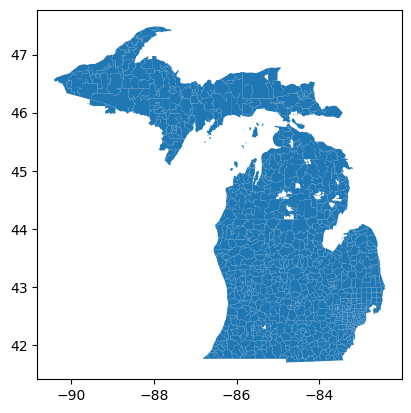

In [66]:
gdf_zcta = gpd.read_file(ZCTA_2019_GIS_FP)
is_michigan_zcta = gdf_zcta["ZCTA5CE10"].isin(mi_zctas)
gdf_mi_zcta = gdf_zcta[is_michigan_zcta].copy()
assert len(gdf_mi_zcta) == len(mi_zctas)
del gdf_zcta
gdf_mi_zcta.plot()

In [67]:
gdf_mi_zcta.columns = [col.lower() for col in gdf_mi_zcta.columns]
zcta_len = gdf_mi_zcta["geoid10"].str.len().iloc[0]
gdf_mi_zcta

,zcta5ce10,geoid10,classfp10,mtfcc10,funcstat10,aland10,awater10,intptlat10,intptlon10,geometry
67,48755,48755,B5,G6350,S,131029849,20512556,+43.7915009,-083.2456200,"POLYGON ((-83.41544 43.92114, -83.39695 43.925..."
70,48756,48756,B5,G6350,S,202486674,4736879,+44.2337465,-083.9733794,"POLYGON ((-84.07325 44.20470, -84.07271 44.205..."
71,48757,48757,B5,G6350,S,142676438,81277,+43.4698587,-083.6763108,"POLYGON ((-83.77807 43.47867, -83.76873 43.478..."
74,48759,48759,B5,G6350,S,128709839,4471377,+43.7304776,-083.3859038,"MULTIPOLYGON (((-83.29783 43.77178, -83.29595 ..."
76,48760,48760,B5,G6350,S,70938037,1815907,+43.3230508,-083.2550060,"POLYGON ((-83.30851 43.27020, -83.30782 43.270..."
...,...,...,...,...,...,...,...,...,...,...
32800,49927,49927,B5,G6350,S,45235512,809145,+46.0306662,-088.5350148,"POLYGON ((-88.62842 46.05832, -88.62830 46.058..."
32801,49929,49929,B5,G6350,S,45763820,0,+46.7727770,-089.1882550,"POLYGON ((-89.18825 46.77278, -89.18825 46.772..."
32804,49930,49930,B5,G6350,S,126693316,12172021,+47.1654800,-088.5396642,"POLYGON ((-88.64124 47.17230, -88.63904 47.174..."
32805,49931,49931,B5,G6350,S,73201595,7107138,+47.0843753,-088.5727865,"POLYGON ((-88.69090 47.18530, -88.69078 47.188..."


## Merge

In [68]:
df_zcta_income_demographics = pd.merge(
    DF_ZCTA_DEMOGRAPHICS, DF_ZCTA_INCOME, validate="1:1"
)
df_zcta_income_demographics["geo_id"] = df_zcta_income_demographics["geo_id"].str.slice(
    -1 * zcta_len
)
df_zcta_income_demographics

,geo_id,geo_name,tot_pop,latin_tot,white_tot,black_tot,latin_pct,white_pct,black_pct,median_income
0,48001,ZCTA5 48001,11903,122,11506,12,1.0,96.7,0.1,59671
1,48002,ZCTA5 48002,3224,33,3150,0,1.0,97.7,0.0,74615
2,48003,ZCTA5 48003,6047,284,5683,1,4.7,94.0,0.0,71908
3,48005,ZCTA5 48005,5509,140,5217,42,2.5,94.7,0.8,77656
4,48006,ZCTA5 48006,4058,44,3878,17,1.1,95.6,0.4,70650
...,...,...,...,...,...,...,...,...,...,...
984,49969,ZCTA5 49969,1259,6,882,8,0.5,70.1,0.6,41875
985,49970,ZCTA5 49970,292,3,286,0,1.0,97.9,0.0,48958
986,49971,ZCTA5 49971,478,17,438,0,3.6,91.6,0.0,41750
987,54540,ZCTA5 54540,916,21,886,0,2.3,96.7,0.0,43824


In [69]:
gdf_zcta_demographics = gdf_mi_zcta.merge(
    df_zcta_income_demographics, left_on="geoid10", right_on="geo_id", validate="1:1"
)
assert (
    len(gdf_zcta_demographics) == len(df_zcta_income_demographics) == len(mi_zctas)
), print(
    f"{len(gdf_zcta_demographics)}, {len(df_zcta_income_demographics)}, {len(mi_zctas)}"
)
gdf_zcta_demographics

,zcta5ce10,geoid10,classfp10,mtfcc10,funcstat10,aland10,awater10,intptlat10,intptlon10,geometry,geo_id,geo_name,tot_pop,latin_tot,white_tot,black_tot,latin_pct,white_pct,black_pct,median_income
0,48755,48755,B5,G6350,S,131029849,20512556,+43.7915009,-083.2456200,"POLYGON ((-83.41544 43.92114, -83.39695 43.925...",48755,ZCTA5 48755,2993,91,2787,32,3.0,93.1,1.1,52321
1,48756,48756,B5,G6350,S,202486674,4736879,+44.2337465,-083.9733794,"POLYGON ((-84.07325 44.20470, -84.07271 44.205...",48756,ZCTA5 48756,4630,98,4369,3,2.1,94.4,0.1,32685
2,48757,48757,B5,G6350,S,142676438,81277,+43.4698587,-083.6763108,"POLYGON ((-83.77807 43.47867, -83.76873 43.478...",48757,ZCTA5 48757,3742,151,3505,22,4.0,93.7,0.6,63813
3,48759,48759,B5,G6350,S,128709839,4471377,+43.7304776,-083.3859038,"MULTIPOLYGON (((-83.29783 43.77178, -83.29595 ...",48759,ZCTA5 48759,3211,19,3135,34,0.6,97.6,1.1,50857
4,48760,48760,B5,G6350,S,70938037,1815907,+43.3230508,-083.2550060,"POLYGON ((-83.30851 43.27020, -83.30782 43.270...",48760,ZCTA5 48760,1419,36,1293,82,2.5,91.1,5.8,50451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,49927,49927,B5,G6350,S,45235512,809145,+46.0306662,-088.5350148,"POLYGON ((-88.62842 46.05832, -88.62830 46.058...",49927,ZCTA5 49927,475,1,453,18,0.2,95.4,3.8,49375
985,49929,49929,B5,G6350,S,45763820,0,+46.7727770,-089.1882550,"POLYGON ((-89.18825 46.77278, -89.18825 46.772...",49929,ZCTA5 49929,230,0,224,0,0.0,97.4,0.0,54375
986,49930,49930,B5,G6350,S,126693316,12172021,+47.1654800,-088.5396642,"POLYGON ((-88.64124 47.17230, -88.63904 47.174...",49930,ZCTA5 49930,7258,215,6752,14,3.0,93.0,0.2,42723
987,49931,49931,B5,G6350,S,73201595,7107138,+47.0843753,-088.5727865,"POLYGON ((-88.69090 47.18530, -88.69078 47.188...",49931,ZCTA5 49931,9600,177,8013,206,1.8,83.5,2.1,30687


## Export

In [70]:
DF_ZCTA_DEMOGRAPHICS.to_csv(ZCTA_DEMOGRAPHICS_EXPORT_FP, index=False)
assert gdf_zcta_demographics["white_tot"].sum() > gdf_zcta_demographics["black_tot"].sum()
gdf_zcta_demographics.to_file(ZCTA_MAP_EXPORT_FP, driver="GeoJSON")